### Creating dataset for Classification

The original dataset is already augmented and inside the _Fish\_Dataset_ folder. The images and masks of the same class are grouped inside the same folder. The dataset structure will be redefined by splitting the data into three folders: train, val and test. Each file will be renamed to 00X\_YYYYY.png, where X is the class in $0, 1, \dots , 8$ and YYYYY the number of the image in the class.

In [1]:
source_dir = 'dataset/Fish_Dataset/Fish_Dataset'
target_dir = 'dataset/project_dataset'

seed = 1234

In [2]:
import os, os.path as osp
import shutil

def list_join_dir(dir):
    return sorted([osp.join(dir, f) for f in os.listdir(dir)])

def list_img_mask(dir):
    candidates = list_join_dir(dir)
    mask_dir = list(filter(lambda x: x.endswith('GT'), candidates))[0]
    img_dir = list(filter(lambda x: not x.endswith('GT'), candidates))[0]

    return list_join_dir(img_dir), list_join_dir(mask_dir)

class Image:
    def __init__(self, source_img_path, source_mask_path, img_final_name) -> None:
        self.source_img_path = source_img_path
        self.source_mask_path = source_mask_path
        self.img_final_name = img_final_name + '.png'

    def copy_to(self, img_dir, mask_dir):
        shutil.copy2(self.source_img_path, osp.join(img_dir, self.img_final_name))
        shutil.copy2(self.source_mask_path, osp.join(mask_dir, self.img_final_name))


# class directories
dir_class = [f for f in list_join_dir(source_dir) if osp.isdir(f)]


all_images = []
for img_class, dir in enumerate(dir_class):
    # list files
    imgs, masks = list_img_mask(dir)
    all_images += [Image(i, m, f'{img_class:03}_{idx:05}') for idx, (i, m) in enumerate(zip(imgs, masks))]

In [3]:
# Split data
from sklearn.model_selection import train_test_split

# train, val, test (60%, 20%, 20%)
train_set, test_set = train_test_split(all_images, test_size=0.4, random_state=seed)
val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=seed)


In [4]:
train_set[0].img_final_name

'008_00307.png'

In [5]:
# Copy data to classification dataset

import os

def create_dir(dir):
    try:
        os.makedirs(dir)
    except FileExistsError:
        pass

def copy_rename_files(img_list, target_dir):
    img_dir = osp.join(target_dir, 'images')
    mask_dir = osp.join(target_dir, 'masks')
    create_dir(img_dir)
    create_dir(mask_dir)

    for img in img_list:
        img.copy_to(img_dir, mask_dir)

copy_rename_files(train_set, osp.join(target_dir, 'train'))
copy_rename_files(val_set, osp.join(target_dir, 'val'))
copy_rename_files(test_set, osp.join(target_dir, 'test'))

### Building a Dataloader

Now I'm going to create a basic dataloader class for this dataset. Probably it will be changes in the next notebooks in order to achieve the desired needs.

All the data will be loaded to the memory. It is possible due to the dataset size.

In [7]:
import cv2
from PIL import Image
import os, os.path as osp

def list_join_dir(dir):
    return sorted([osp.join(dir, f) for f in os.listdir(dir)])

class Dataloader():
    def __init__(self, set_dir, apply_mask=False, transforms=None) -> None:
        self.set_dir = set_dir
        self.apply_mask = apply_mask
        self.transforms = transforms

        self.img_dir = osp.join(set_dir, 'images')
        self.mask_dir = osp.join(set_dir, 'masks')

        self.images, self.gts = [], []
        for img_path in list_join_dir(self.img_dir):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img_basename = osp.basename(img_path)
            
            if self.apply_mask:
                mask_path = osp.join(self.mask_dir, img_basename)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.bitwise_and(img, img, mask=mask)

            self.images.append(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
            self.gts.append(int(img_basename.split('.')[0].split('_')[0]))

    def __getitem__(self, idx):
        if self.transforms:
            return self.transforms(self.images[idx]), self.gts[idx]
        return self.images[idx], self.gts[idx]
    
    def __len__(self):
        return len(self.images)
        

In [13]:
t = Dataloader('./dataset/project_dataset/test', apply_mask=True)

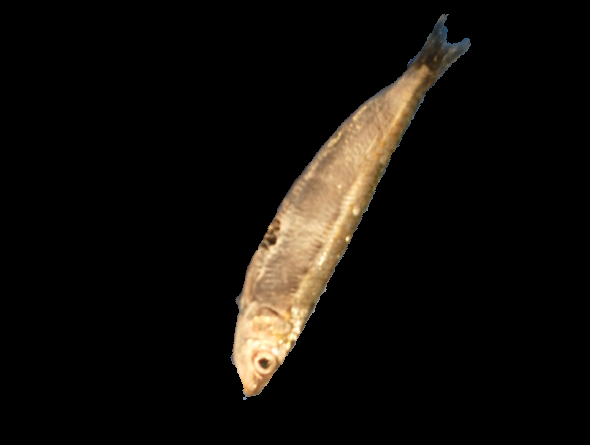

In [14]:
t[0][0]